In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.utils import shuffle
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16
import collections
import time
import math
from sklearn.decomposition import PCA

In [30]:
# Create Training Data
path = './OULP-C1V2_Pack/OULP-GEI-(64x64)-5f-full_add_more_data_model/decoded_probe_5f-full_3'

Seq = np.ndarray([1000,64,64], dtype=float)
for ii in range(1, 1001):
    seq_path = path + '/' + str(ii) + '.png'
    Seq[ii-1] = imread(seq_path)

In [31]:
with open('../gait_data/OULP_GEI/GEI64x64_5f-full_3_Seq01', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [113]:
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

gallery_5f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_Seq00', mode='rb'))
probe_5f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_Seq01', mode='rb'))

gallery_5f_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_2_Seq00', mode='rb'))
probe_5f_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_2_Seq01', mode='rb'))

gallery_5f_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_3_Seq00', mode='rb'))
probe_5f_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_3_Seq01', mode='rb'))

pred_gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_Seq00', mode='rb'))
pred_probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_Seq01', mode='rb'))
pred_gallery_full_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_2_Seq00', mode='rb'))
pred_probe_full_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_2_Seq01', mode='rb'))
pred_gallery_full_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_3_Seq00', mode='rb'))
pred_probe_full_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_3_Seq01', mode='rb'))

In [114]:
# 5f
gallery_5f = gallery_5f[2146:, 3]
probe_5f = probe_5f[2146:, 3]

gallery_5f_2 = gallery_5f_2[2146:, 3]
probe_5f_2 = probe_5f_2[2146:, 3]

gallery_5f_3 = gallery_5f_3[2146:, 3]
probe_5f_3 = probe_5f_3[2146:, 3]

# full
gallery_full = gallery_full[2146:, 3]
probe_full = probe_full[2146:, 3]

In [115]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

gallery_5f = gallery_5f/float(255)
probe_5f = probe_5f/float(255)

gallery_5f_2 = gallery_5f_2/float(255)
probe_5f_2 = probe_5f_2/float(255)

gallery_5f_3 = gallery_5f_3/float(255)
probe_5f_3 = probe_5f_3/float(255)

# Calculate possible L2 distance

In [234]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

def calculate_L2(gallery_list, probe_list):
    
    Total_L2_list = []
    Total_label = []
    for ii, probe in enumerate(probe_list):
        
        L2_for_every_probe = []
        
        label = []
        
        for jj, gallery in enumerate(gallery_list):
            
            L2_distance = np.sqrt(np.sum(np.square(gallery-probe)))
            
            if ii == jj:
                label.append(1.0)
            else: 
                label.append(0.0)
                
            L2_for_every_probe.append(L2_distance)
        
        Total_label.append(np.array(label))
            
        Total_L2_list.append(np.array(L2_for_every_probe))
        
    return np.array(Total_L2_list), np.array(Total_label)

def Find_rank_i_accuracy(L2_list, Label, rank_i):
    min_L2 = None
    right_match = 0
    L2_1 = np.ndarray([1000])
    
    for L2, label in zip(L2_list,Label):
        
        min_L2_index_list = []
        L2_1 = L2.copy()
        
        for ii in range(rank_i):
#             min_L2 = np.min(L2)
            min_index = np.argmin(L2_1)
            min_L2_index_list.append(min_index)
            L2_1[min_index] = 1000
            
#         print(min_L2_index_list)
        for every_index in min_L2_index_list:
            if np.argmax(label) == every_index:
                right_match += 1
                break
                
    return (right_match/ 1000.0) *100.0
        
        
        
# Flatten
def flatten(x):
    return np.reshape(x, [-1, x.shape[1] * x.shape[2]])

## Accuracy of original full GEI

###  Set L2 as Threshold 

In [315]:
fla_gallery_full = flatten(gallery_full)
fla_probe_full = flatten(probe_full)

In [316]:
# zero mean
gallery_mean_value = np.sum(np.concatenate([gallery_full, probe_full], axis=0)) / (len(gallery_full) * 2 * 64 * 64)
zeromean_gallery_full = fla_gallery_full - gallery_mean_value
zeromean_probe_full = fla_probe_full - gallery_mean_value

In [317]:
# pca
pca = PCA(n_components=0.99)
pca_full = pca.fit_transform(np.concatenate([zeromean_gallery_full, zeromean_probe_full], axis=0))
# pca_probe_full = pca.fit_transform(zeromean_probe_full)

In [318]:
L2_full_list, Label_full = calculate_L2(pca_full[:1000], pca_full[1000:])
L2_full_3bit = np.around(L2_full_list, decimals=2)

In [302]:
L2_full_list, Label_full = calculate_L2(gallery_full, probe_full)
L2_full_3bit = np.around(L2_full_list, decimals=2)

In [374]:
def generate_CMC(L2_3bit, Label, rank):
    CMC_point = []
    
    for rank_i in np.arange(1, rank+1, 1):
        CMC_point.append(Find_rank_i_accuracy(L2_3bit, Label, rank_i))
#     CMC_point.append(100) 
    return np.array(CMC_point)

In [367]:
Find_rank_i_accuracy(L2_full_3bit, Label, 1)

90.0

(81.0, 100)

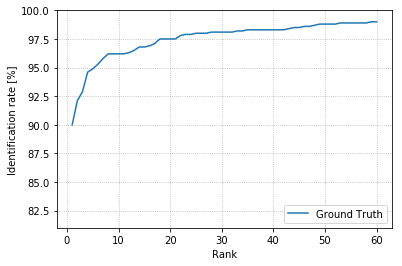

In [375]:
CMC_point_full = generate_CMC(L2_full_3bit, Label_full, 60)
# f1 = plt.figure(1)
plt.xlabel('Rank')
plt.ylabel('Identification rate [%]')
plt.grid(linestyle=':')
plt.plot(np.arange(1, 60+1, 1), CMC_point_full, label='Ground Truth') 
plt.legend(loc='lower right')
plt.ylim(np.array(CMC_point_full).min() * 0.9, 100)    

In [ ]:
with open('./Recognition rate/PCA_99%/FAR_array_full', 'wb') as f:
    np.save(f, np.array(FAR_full))

In [513]:
x=np.concatenate([np.reshape(FAR_array, [len(FAR_array),1]), np.reshape(FRR_array, [len(FRR_array),1])], axis=1)

## Accuracy of pred GEI

## set L2 as threshold

In [337]:
fla_gallery_pred = flatten(pred_gallery_full_3)
fla_probe_pred = flatten(pred_probe_full_3)

In [338]:
# zero mean
gallery_mean_value = np.sum(np.concatenate([pred_gallery_full, pred_probe_full], axis=0)) / (2000 * 64 * 64)
zeromean_gallery_pred = fla_gallery_pred - gallery_mean_value
zeromean_probe_pred = fla_probe_pred - gallery_mean_value

In [339]:
# pca
pca = PCA(n_components=0.99)
pca_pred = pca.fit_transform(np.concatenate([zeromean_gallery_pred, zeromean_probe_pred], axis=0))
# pca_probe_full = pca.fit_transform(zeromean_probe_full)

In [340]:
L2_pred_list, Label_pred = calculate_L2(pca_pred[:1000], pca_pred[1000:])
L2_pred_3bit = np.around(L2_pred_list, decimals=2)

In [341]:
Find_rank_i_accuracy(L2_pred_3bit, Label_pred, 1)

64.4

(57.960000000000008, 100)

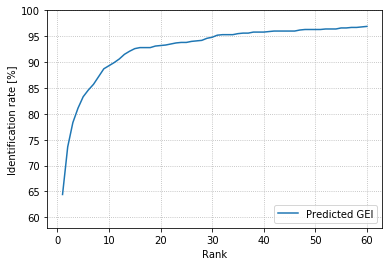

In [378]:
CMC_point_pred = generate_CMC(L2_pred_3bit, Label_pred, 60)
plt.xlabel('Rank')
plt.ylabel('Identification rate [%]')
plt.grid(linestyle=':')
plt.plot(np.arange(1, 60+1, 1), CMC_point_pred, label='Predicted GEI') 
plt.legend(loc='lower right')
plt.ylim(np.array(CMC_point_pred).min() * 0.9, 100)    

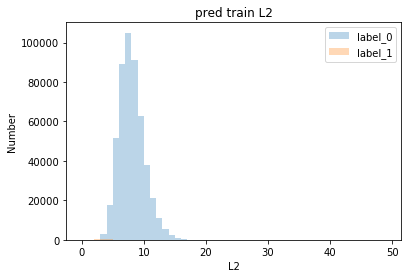

In [716]:
L2_pred, label_pred = shuffle(L2_pred, label_pred)
L2_pred_3bit = np.around(L2_pred, decimals=2)

# Histgram
bins = np.arange(50)

plt.hist(np.concatenate([L2_0_Pred, L2_0_test_Pred],axis=0), bins=bins, alpha=0.3, label='label_0')
plt.hist(np.concatenate([L2_1_Pred, L2_1_test_Pred],axis=0), bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('pred train L2')
plt.xlabel('L2')
plt.ylabel('Number')
plt.legend(loc='upper right')
 
plt.show()

In [736]:
with open('./Recognition rate/PCA_99%/FAR_Pred', 'wb') as f:
    np.save(f, np.array(FAR_pred))
    
with open('./Recognition rate/PCA_99%/FRR_Pred', 'wb') as f:
    np.save(f, np.array(FRR_pred))

In [ ]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

## Accuracy of 5f GEI

In [30]:
# map_5f, label_5f = calculate_L2(gallery_5f[:500], probe_5f_2[:500])
# map_5f_1, label_5f_1 = calculate_L2(gallery_5f[:500], probe_5f_3[:500])
# map_5f_2, label_5f_2 = calculate_L2(gallery_5f[:500], probe_5f[:500])
# map_5f_3, label_5f_3 = calculate_L2(gallery_5f_2[:500], probe_5f_2[:500])
# map_5f_4, label_5f_4 = calculate_L2(gallery_5f_2[:500], probe_5f_3[:500])
# map_5f_5, label_5f_5 = calculate_L2(gallery_5f_2[:500], probe_5f[:500])
# map_5f_6, label_5f_6 = calculate_L2(gallery_5f_3[:500], probe_5f_2[:500])
# map_5f_7, label_5f_7 = calculate_L2(gallery_5f_3[:500], probe_5f_3[:500])
# map_5f_8, label_5f_8 = calculate_L2(gallery_5f_3[:500], probe_5f[:500])

# MAP_5f = np.concatenate([map_5f,map_5f_1,map_5f_2,map_5f_3,map_5f_4,map_5f_5,map_5f_6,map_5f_7,map_5f_8], axis=0)
# Label_5f = np.concatenate([label_5f,label_5f_1,label_5f_2,label_5f_3,label_5f_4,label_5f_5,label_5f_6,label_5f_7,label_5f_8], axis=0)

## set L2 as threshold

In [380]:
fla_gallery_5f = flatten(gallery_5f)
fla_probe_5f = flatten(probe_5f)

In [381]:
# zero mean
gallery_mean_value = np.sum(np.concatenate([fla_gallery_5f, fla_probe_5f], axis=0)) / (2000 * 64 * 64)
zeromean_gallery_5f = fla_gallery_5f - gallery_mean_value
zeromean_probe_5f = fla_probe_5f - gallery_mean_value

In [382]:
# pca
pca = PCA(n_components=0.99)
pca_5f = pca.fit_transform(np.concatenate([zeromean_gallery_5f, zeromean_probe_5f], axis=0))

In [383]:
L2_5f_list, Label_5f = calculate_L2(pca_5f[:1000], pca_5f[1000:])
L2_5f_3bit = np.around(L2_5f_list, decimals=2)

In [387]:
Find_rank_i_accuracy(L2_5f_3bit, Label_5f, 1)

15.6

(14.039999999999999, 100)

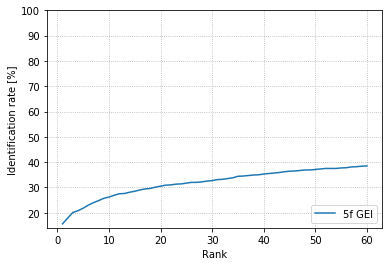

In [389]:
CMC_point_5f = generate_CMC(L2_5f_3bit, Label_5f, 60)
plt.xlabel('Rank')
plt.ylabel('Identification rate [%]')
plt.grid(linestyle=':')
plt.plot(np.arange(1, 60+1, 1), CMC_point_5f, label='5f GEI') 
plt.legend(loc='lower right')
plt.ylim(np.array(CMC_point_5f).min() * 0.9, 100)    

(14.039999999999999, 100)

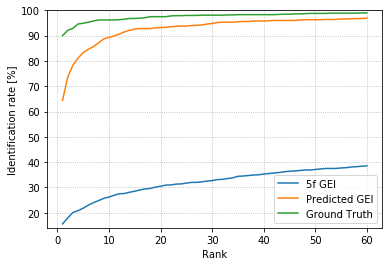

In [391]:
plt.xlabel('Rank')
plt.ylabel('Identification rate [%]')
plt.grid(linestyle=':')
plt.plot(np.arange(1, 60+1, 1), CMC_point_5f, label='5f GEI')
plt.plot(np.arange(1, 60+1, 1), CMC_point_pred, label='Predicted GEI')
plt.plot(np.arange(1, 60+1, 1), CMC_point_full, label='Ground Truth') 
plt.legend(loc='lower right')
plt.ylim(np.array(CMC_point_5f).min() * 0.9, 100)    

## KNN

In [490]:
L2_label_1_5f, label_1_5f, L2_label_0_5f, label_0_5f = calculate_L2(gallery_5f[:500], probe_5f[:500])
L2_label_1_test_5f, label_1_test_5f, L2_label_0_test_5f, label_0_test_5f = calculate_L2(gallery_5f[500:], probe_5f[500:])

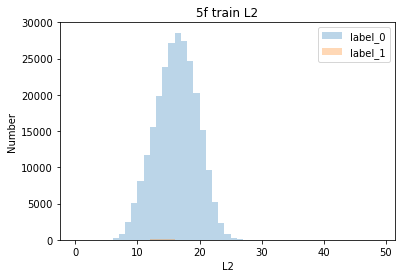

In [256]:
bins = np.arange(50)

plt.hist(L2_label_0_5f, bins=bins, alpha=0.3, label='label_0')
plt.hist(L2_label_1_5f, bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('5f train L2')
plt.xlabel('L2')
plt.ylabel('Number')
plt.legend(loc='upper right')
 
plt.show()

In [253]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.concatenate([L2_label_1_5f, L2_label_0_5f], axis=0), 
          np.concatenate([label_1_5f, label_0_5f], axis=0)) 

# pred_5f = neigh.predict(np.concatenate([L2_label_1_test_5f, L2_label_0_test_5f[:500]], axis=0))
# calculate_acc(pred_5f, np.concatenate([label_1_test_5f, label_0_test_5f[:500]], axis=0))

pred_5f = neigh.predict(np.concatenate([L2_label_1_test_5f, L2_label_0_test_5f], axis=0))
calculate_acc(pred_5f, np.concatenate([label_1_test_5f, label_0_test_5f], axis=0))

99.632000000000005

ValueError: Number of features of the model must match the input. Model n_features is 1 and input n_features is 2 

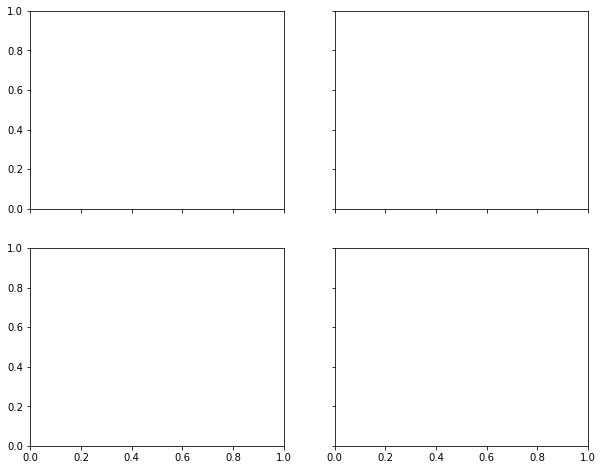

In [254]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
# iris = datasets.load_iris()
# X = iris.data[:, [0, 2]]
# y = iris.target

X = MAP_5f
y = Label_5f

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighmin_FAR, min_FRRbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:].min() - 1, X[:].max() + 1
y_min, y_max = 0 - 1, 1 + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

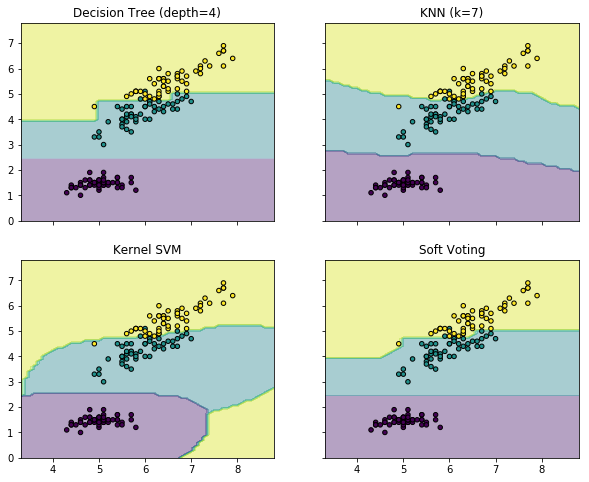

In [188]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Calculate SSIM and MSE

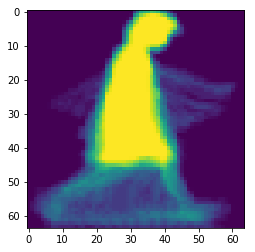

In [50]:
plt.imshow(gallery_full[0])

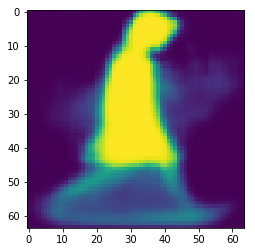

In [52]:
plt.imshow(pred_gallery_full_2[0])

In [79]:
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [103]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
 
def compare_images(imageA, imageB, title_1, title_2):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    # setup the figure
    fig = plt.figure()
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(title_1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(title_2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

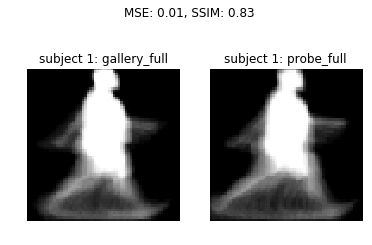

In [141]:
compare_images(gallery_full[1], probe_full[1], 'subject 1: gallery_full', 'subject 1: probe_full')

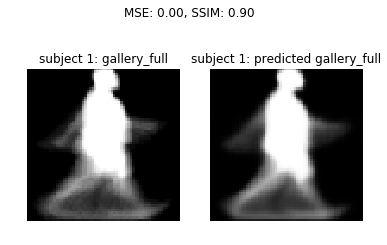

In [142]:
compare_images(gallery_full[1], pred_gallery_full[1], 'subject 1: gallery_full', 'subject 1: predicted gallery_full')

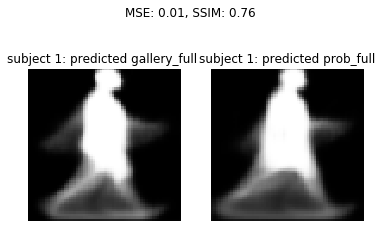

In [143]:
compare_images(pred_gallery_full[1], pred_probe_full[1], 'subject 1: predicted gallery_full ', 'subject 1: predicted prob_full')

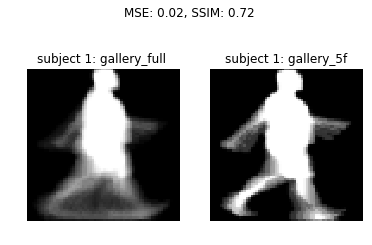

In [144]:
compare_images(gallery_full[1], gallery_5f[1], 'subject 1: gallery_full ', 'subject 1: gallery_5f')

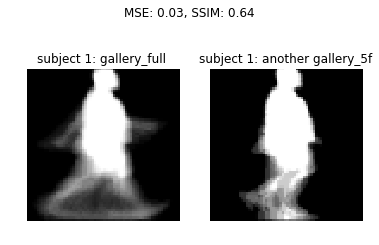

In [147]:
compare_images(gallery_full[1], gallery_5f_2[1], 'subject 1: gallery_full ', 'subject 1: another gallery_5f')

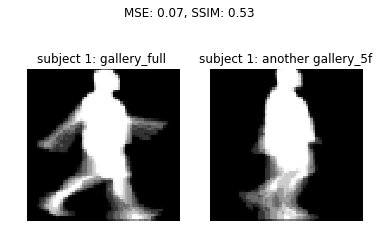

In [164]:
compare_images(gallery_5f[1], gallery_5f_2[1], 'subject 1: gallery_full ', 'subject 1: another gallery_5f')

In [170]:
np.sqrt(np.sum(np.square(gallery_5f[5] - probe_5f[2])))

12.43250876232695